## Recipient Extraction


Giacomo Grazia

Final Bachelor Project TU/e & TiU

Academic Year 2024-2025

In [269]:
# imports
import pandas as pd
import json
from tqdm import tqdm
tqdm.pandas()
from openai import OpenAI
import spacy
import ast
import random
from IPython.display import HTML




df = pd.read_csv('data_recipient_extraction.csv')

# Convert the "extracted_parties_gpt_v3" column to lists
df["extracted_parties_gpt_v3"] = df["extracted_parties_gpt_v3"].apply(
    lambda x: ast.literal_eval(x) if pd.notnull(x) else []
)
df.party_labeled = df.party_labeled.apply(lambda x: x.split(",") if pd.notnull(x) else [])

df.party_labeled = df.party_labeled.apply(lambda x: [y.strip(' ').strip('\r\n').replace('\r\n', '').replace('\n', '').replace('None / Multiple', '') for y in x])


### 0. Quick EDA of labeled parties

In [188]:
# number of distinct elements across all lists
distinct_elements_gt = set()
for parties in df['party_labeled']:
    if len(parties) == 0:
        continue
    else:
        for party in parties:
            distinct_elements_gt.add(party)

distinct_count_ground_truth = len(distinct_elements_gt)

# how many lists contain only the element "none" (=no parties found)
none_only_count_ground_truth = df['party_labeled'].apply(lambda x: all(((p == 'none') or (p==[])) for p in x)).sum()

# Display the results
print(f"Number of distinct parties in ground truth labels: {distinct_count_ground_truth}")
print(f"Number of lists containing no parties: {none_only_count_ground_truth}")

Number of distinct parties in ground truth labels: 223
Number of lists containing no parties: 28


Mean number of parties: 1.17
Median number of parties: 1.0
Standard deviation of number of parties: 0.58


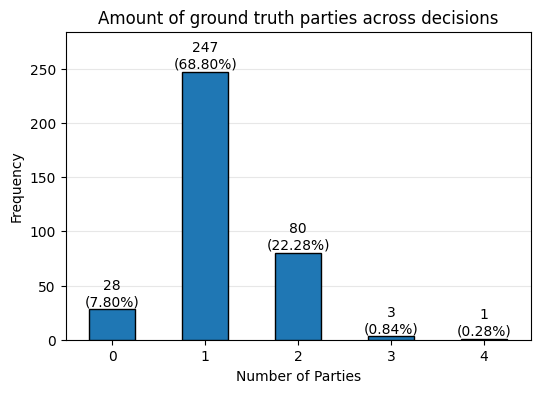

In [250]:
import matplotlib.pyplot as plt

# Calculate the number of parties in each row
df['party_count'] = df.apply(lambda x: len(x['party_labeled']), axis=1)

# Calculate mean and median
mean_party_count = df['party_count'].mean()
median_party_count = df['party_count'].median()
std_party_count = df['party_count'].std()


print(f"Mean number of parties: {mean_party_count:.2f}")
print(f"Median number of parties: {median_party_count}")
print(f"Standard deviation of number of parties: {std_party_count:.2f}")

# Plot the bar chart
ax = df['party_count'].value_counts().sort_index().plot(kind='bar', figsize=(6, 4), edgecolor='black', zorder=3)

# Adjust the y-axis limit to raise the top bar
max_count = df['party_count'].value_counts().max()
ax.set_ylim(0, max_count * 1.15)

# Add counts and proportions on top of each bar
total_count = len(df)
for p in ax.patches:
    count = p.get_height()
    proportion = count / total_count
    ax.annotate(f'{count}\n({proportion:.2%})', 
                (p.get_x() + p.get_width() / 2., p.get_height()+2), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')


# Customize the plot
plt.xlabel('Number of Parties')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='-', alpha=0.3, zorder=0)
plt.title('Amount of ground truth parties across decisions')
plt.xticks(rotation=0)  # Set x-tick labels to horizontal
plt.savefig('/Users/giacomograzia/Downloads/party_count_distribution.png', dpi=300)

# Show the plot
plt.show()

In [259]:
mean_combined_text_length = df.combined_text.apply(lambda x: len(x.split(' '))).mean().round(2)
median_combined_text_length = df.combined_text.apply(lambda x: len(x.split(' '))).median().round(2)
std_combined_text_length = df.combined_text.apply(lambda x: len(x.split(' '))).std().round(2)

print(f"Mean length of combined text: {mean_combined_text_length}")
print(f"Median length of combined text: {median_combined_text_length}")
print(f"Standard deviation of combined text length: {std_combined_text_length}")

Mean length of combined text: 31.71
Median length of combined text: 29.0
Standard deviation of combined text length: 8.13


In [260]:
mean_text_pypdf2_length = df.text_pypdf2.apply(lambda x: len(x.split(' '))).mean().round(2)
median_text_pypdf2_length = df.text_pypdf2.apply(lambda x: len(x.split(' '))).median().round(2)
std_text_pypdf2_length = df.text_pypdf2.apply(lambda x: len(x.split(' '))).std().round(2)

print(f"Mean length of combined text: {mean_text_pypdf2_length}")
print(f"Median length of combined text: {median_text_pypdf2_length}")
print(f"Standard deviation of combined text length: {std_text_pypdf2_length}")

Mean length of combined text: 1633.53
Median length of combined text: 1640.0
Standard deviation of combined text length: 1710.47


### 1. NER

#### 1.1 Baseline model with no domain-specific fine tuning. Only SpaCy training on news.

In [264]:
# Load the Dutch language model with NER capabilities
nlp = spacy.load("nl_core_news_lg")

def extract_organizations(text: str) -> list:
    """
    Extracts all organizations (ORG entities) from the provided text.
    
    :param text: A string containing the text to process.
    :return: A list of organization names identified in the text.
    """
    doc = nlp(text)
    
    # Extract and return all entities labeled as ORG
    organizations = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
    return organizations

df_temp = df.head(20).copy()

# Apply the function to extract organizations and store them in a new column
df_temp['organizations'] = df_temp['text_pypdf2'].apply(extract_organizations)

df_temp[["parties", "organizations"]]

,parties,organizations
0,TotalEnergies Power & Gas NL,"[kleinverbruikers.1 1, acm, acm, acm, acm, acm..."
1,TotalEnergies Power & Gas NL,"[kleinverbruikers.1 1, acm, acm, acm, acm, acm..."
2,De Vrije Energie Producent B.V. Qwint B.V,"[kleinverbruikers.1 1, acm, hvc, acm, hvc, acm..."
3,De Vrije Energie Producent B.V. Qwint B.V,"[kleinverbruikers.1 1, acm, hvc, acm, hvc, hvc..."
4,NaN,"[acm, acm, acm, acm, acm, acm, acm, acm, acm, ..."
5,Energie der Nederlanden,"[acm/uit/177356, acm, edn, acm, edn, acm/uit/1..."
6,NaN,"[acm/uit/126178, acm, acm, acm, acm, acm, acm,..."
7,NaN,"[acm, acm, acm, acm, acm, acm, acm, acm, acm, ..."
8,Delta Energy B.V.,"[acm, acm, acm, acm, college van beroep voor h..."
9,NaN,"[acm, acm, college van burgemeester en wethoud..."


#### 1.2 Custom NER (with domain specific fine-tuning)

In [265]:
import re
from fuzzywuzzy import fuzz

def prepare_training_data(df, threshold=70):
    """
    Prepares training data for spaCy NER from a DataFrame, handling partial matches and overlap using fuzzy matching.
    Returns the original party as a separate element for easy DataFrame conversion.

    :param df: A DataFrame containing headlines and ground truth ontvangers.
    :param threshold: Minimum similarity score for a match (default: 70).
    :return: A list of tuples (headline, entities, original_party).
    """
    training_data = []

    for idx, row in df.iterrows():
        headline = row['headline']
        ontvanger = row['parties']  # Ground truth ontvanger

        # Ensure both headline and ontvanger are not NaN or None
        if pd.notna(headline) and pd.notna(ontvanger):
            matched = None
            best_score = 0
            best_match = None

            # Split ontvanger into parts and check for fuzzy matches
            ontvanger_parts = ontvanger.split()
            for part in ontvanger_parts:
                # Regex-based exact word match
                match = re.search(r'\b' + re.escape(part) + r'\b', headline, flags=re.IGNORECASE)
                if match:
                    matched = match
                    break

                # Fuzzy matching for approximate matches
                score = fuzz.partial_ratio(part.lower(), headline.lower())
                if score > best_score and score >= threshold:
                    best_score = score
                    best_match = part

            # If a regex match is found
            if matched:
                start = matched.start()
                end = matched.end()
                training_data.append((headline, [(start, end, "ORG")], ontvanger))
            # If a fuzzy match is found
            elif best_match:
                start = headline.lower().find(best_match.lower())
                end = start + len(best_match)
                training_data.append((headline, [(start, end, "ORG")], ontvanger))
            else:
                print(f"Warning: Ontvanger '{ontvanger}' not found in headline: {headline}")

    return training_data

# Prepare the dataset with entities for training and testing
NER_LABELS_SPACY = prepare_training_data(df)

Visualizing the fuzzy matched training data

In [270]:
from spacy import displacy

def visualize_fuzzy_matched_training_data(training_data, num_examples=5, seed=42):
    """
    Visualizes examples of fuzzy-matched training data using spaCy's displacy.

    :param training_data: List of training examples in the format (headline, entities, original_party).
    :param num_examples: Number of examples to visualize.
    :param seed: Seed for random sampling (default: 42).
    """
    # Set the random seed for reproducibility
    random.seed(seed)
    
    # Randomly sample examples from the training data
    sampled_data = random.sample(training_data, min(num_examples, len(training_data)))
    
    for headline, entities, original_party in sampled_data:
        # Create visualization data
        ents = [{"start": start, "end": end, "label": label} for start, end, label in entities]
        visualization_data = {"text": headline, "ents": ents, "title": "Training Data"}
        
        # Render displacy visualization as HTML
        displacy_html = displacy.render(visualization_data, style="ent", manual=True, jupyter=False)
        
        # Combine textual details and visualization into a styled box
        box_style = """
        <div style="
            border: 1px solid #ddd;
            border-radius: 8px;
            padding: 15px;
            margin: 10px 0;
            background-color: #f9f9f9;">
        """
        
        details = f"""
        {box_style}
        <strong>Headline:</strong> {headline}<br>
        <strong>Entity Extracted for NER Training:</strong> {', '.join([headline[start:end] for start, end, _ in entities])}<br>
        <strong>Original Party (Ground Truth):</strong> {original_party}<br><br>
        {displacy_html}
        </div>
        """
        
        # Display the styled box with content
        display(HTML(details))

# Visualize examples from NER_LABELS_SPACY
visualize_fuzzy_matched_training_data(NER_LABELS_SPACY, num_examples=5, seed=42)


Custom NER training

In [271]:
from sklearn.model_selection import train_test_split

# Train-test split
train_data, test_data = train_test_split(NER_LABELS_SPACY, test_size=0.2, random_state=42)

/Users/giacomograzia/Library/CloudStorage/OneDrive-TUEindhoven/BDS/Y3S1_BEP/BEP_CITaDOG/.conda/lib/python3.12/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Oxxio Nederland B.V. mag gas leveren aan kleinverb..." with entities "[(41, 54, 'ORG')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/Users/giacomograzia/Library/CloudStorage/OneDrive-TUEindhoven/BDS/Y3S1_BEP/BEP_CITaDOG/.conda/lib/python3.12/site-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "AllureNRG mag gas leveren aan kleinverbruikers" with entities "[(0, 6, 'ORG')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/Users/giacomograzia/Library/Clou

Losses at iteration 0: {'tok2vec': 0.0, 'morphologizer': 0.0, 'tagger': 0.0, 'parser': 0.0, 'lemmatizer': 0.0, 'ner': 998.9324717521667}
Losses at iteration 1: {'tok2vec': 0.0, 'morphologizer': 0.0, 'tagger': 0.0, 'parser': 0.0, 'lemmatizer': 0.0, 'ner': 1569.3668894767761}
Losses at iteration 2: {'tok2vec': 0.0, 'morphologizer': 0.0, 'tagger': 0.0, 'parser': 0.0, 'lemmatizer': 0.0, 'ner': 1552.9494185447693}
Losses at iteration 3: {'tok2vec': 0.0, 'morphologizer': 0.0, 'tagger': 0.0, 'parser': 0.0, 'lemmatizer': 0.0, 'ner': 1517.0637447834015}
Losses at iteration 4: {'tok2vec': 0.0, 'morphologizer': 0.0, 'tagger': 0.0, 'parser': 0.0, 'lemmatizer': 0.0, 'ner': 1438.3968648910522}
Losses at iteration 5: {'tok2vec': 0.0, 'morphologizer': 0.0, 'tagger': 0.0, 'parser': 0.0, 'lemmatizer': 0.0, 'ner': 1283.4007136821747}
Losses at iteration 6: {'tok2vec': 0.0, 'morphologizer': 0.0, 'tagger': 0.0, 'parser': 0.0, 'lemmatizer': 0.0, 'ner': 1040.504768371582}
Losses at iteration 7: {'tok2vec': 0

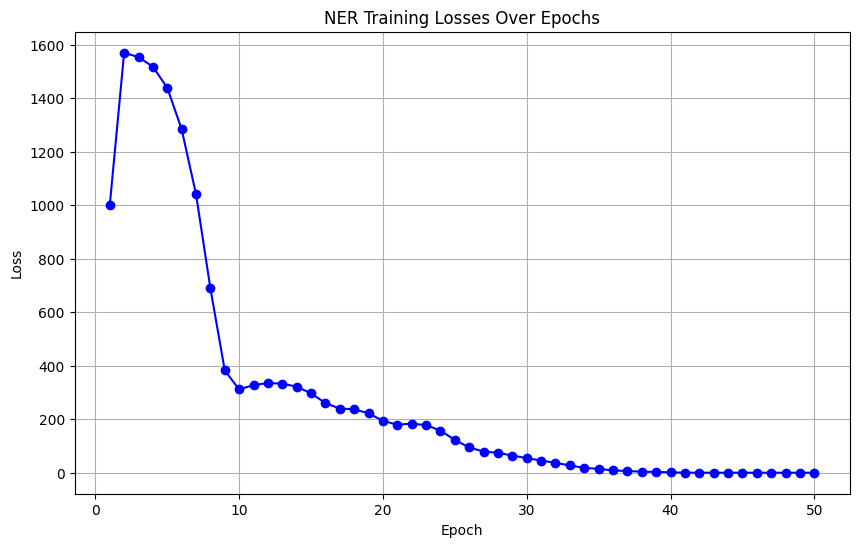

In [272]:
import spacy
from spacy.training import Example
import random
import matplotlib.pyplot as plt

def train_ner_model(train_data, base_model="nl_core_news_lg", n_iter=50):
    """
    Trains a custom NER model using spaCy and plots the training losses.

    :param train_data: List of training examples in the format (headline, entities, original_party).
    :param base_model: The base spaCy model to fine-tune.
    :param n_iter: Number of training iterations.
    :return: The trained spaCy model and a list of losses per epoch.
    """
    # Load the base model
    nlp = spacy.load(base_model)
    ner = nlp.get_pipe("ner")
    ner.add_label("ORG")

    # Prepare training examples, excluding the original party
    examples = [
        Example.from_dict(nlp.make_doc(headline), {"entities": entities})
        for headline, entities, _ in train_data  # Ignore the original party
    ]

    # Train the NER model and track losses
    optimizer = nlp.initialize()
    epoch_losses = []

    for epoch in range(n_iter):
        losses = {}
        random.shuffle(examples)
        nlp.update(examples, sgd=optimizer, losses=losses)
        epoch_losses.append(losses["ner"])
        print(f"Losses at iteration {epoch}: {losses}")

    # Plot the losses over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_iter + 1), epoch_losses, marker='o', linestyle='-', color='b')
    plt.title("NER Training Losses Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

    return nlp, epoch_losses

# Train the model and plot losses
custom_ner, losses = train_ner_model(train_data)


In [273]:
def evaluate_ner_model(nlp, test_data):
    """
    Evaluates the custom NER model on a test dataset.

    :param nlp: The trained spaCy model.
    :param test_data: List of test examples in the format (headline, entities, original_party).
    :return: Precision, recall, and F1-score.
    """
    tp = 0  # True positives
    fp = 0  # False positives
    fn = 0  # False negatives

    for headline, entities, _ in test_data:  # Unpack headline and entities, ignore original_party
        doc = nlp(headline)
        predicted_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
        true_entities = entities

        # Compare predicted and true entities
        for pred in predicted_entities:
            if pred in true_entities:
                tp += 1
            else:
                fp += 1

        for true_ent in true_entities:
            if true_ent not in predicted_entities:
                fn += 1

    # Calculate precision, recall, and F1-score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

# Evaluate the model
precision, recall, f1 = evaluate_ner_model(custom_ner, test_data)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")


/Users/giacomograzia/Library/CloudStorage/OneDrive-TUEindhoven/BDS/Y3S1_BEP/BEP_CITaDOG/.conda/lib/python3.12/site-packages/spacy/pipeline/attributeruler.py:149: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


Precision: 0.87, Recall: 0.83, F1-score: 0.85


In [274]:
from spacy import displacy

def visualize_test_examples_with_displacy(nlp, test_data, num_examples=5):
    """
    Visualizes true and predicted entities from the test set using spaCy's displacy.

    :param nlp: The trained spaCy model.
    :param test_data: List of test examples in the format (headline, entities, original_party).
    :param num_examples: Number of examples to visualize.
    """
    examples_shown = 0

    # Define custom color options
    ground_truth_colors = {"ORG": "green"}
    predicted_colors = {"ORG": "yellow"}

    for headline, entities, original_party in test_data:
        # Stop if the desired number of examples is reached
        if examples_shown >= num_examples:
            break

        # Print metadata
        print(f"Example {examples_shown + 1}")
        print(f"Original Party (Ground Truth): {original_party}")
        print(f"Headline: {headline}")
        
        # True entities visualization
        true_ents = [{"start": start, "end": end, "label": label} for start, end, label in entities]
        true_render = {"text": headline, "ents": true_ents, "title": "True Entities"}
        displacy.render(true_render, style="ent", manual=True, jupyter=True, options={"colors": ground_truth_colors})

        # Predicted entities visualization
        doc = nlp(headline)
        predicted_ents = [{"start": ent.start_char, "end": ent.end_char, "label": ent.label_} for ent in doc.ents]
        predicted_render = {"text": headline, "ents": predicted_ents, "title": "Predicted Entities"}
        displacy.render(predicted_render, style="ent", manual=True, jupyter=True, options={"colors": predicted_colors})

        print("-" * 80)  # Separator between examples
        examples_shown += 1

# Visualize examples
visualize_test_examples_with_displacy(custom_ner, test_data, num_examples=5)


Example 1
Original Party (Ground Truth): Inenergie
Headline: Inenergie mag warmte leveren aan verbruikers


--------------------------------------------------------------------------------
Example 2
Original Party (Ground Truth): Eneco Retail B.V.
Headline: Energievergunning Eneco Retail B.V. voor leveren elektriciteit aan kleinverbruikers komt op naam van Eneco Consumenten B.V.


--------------------------------------------------------------------------------
Example 3
Original Party (Ground Truth): e-Energy Europe B.V., Slim met Energie B.V.
Headline: Energieleveranciers houden zich beter aan regels tijdige facturatie


--------------------------------------------------------------------------------
Example 4
Original Party (Ground Truth): Holthausen Clean Energy B.V.
Headline: Vergunning elektriciteit en gas Holthausen Clean Energy komt op naam van Clean Energy


--------------------------------------------------------------------------------
Example 5
Original Party (Ground Truth): KAS Energie Nederland, Kleinverbruik Energie Nederland
Headline: Vergunning elektriciteit KAS Energie Nederland komt op naam van Kleinverbruik Energie Nederland (KEN).


--------------------------------------------------------------------------------


### 2. LLM-based Party Extraction

#### 2.1 OpenAI api calls

In [ ]:
OpenAI.api_key = OPENAI_API_KEY

# Define a function to preprocess each row and call the API
def process_row(row):
    # Extract fields from the row
    decision_headline = row["headline"]
    decision_description = row["description"]
    parties = row["parties"]
    decision_text = ""  # Default is empty
    
    # Check for the specific case where decision text should be used
    if parties == "Leveringsvergunningen Kleinverbruik Ex Art. 45 Gaswet":
        # get only the first third of the decision text
        decision_text = row.get("text_pypdf2", "")[:len(row.get("text_pypdf2", "")) // 3]

    # Prepare the API prompt
    prompt = f"""
    Given the following headline and description (or text, in case the headline and/or description are unavailable) of an administrative decision, 
    return a list of strings representing each of the parties involved in the decision, as they are written in the headline, description, or text. 
    
    Names might be written in non-(fully)-standard forms, for instance:
        - "Huismerk" instead of "Huismerk Energie N.V."
        - "Treant Ziekenhuiszorg" instead of "Stichting Treant Ziekenhuiszorg"
        - "GDF SUEZ" instead of "GDF SUEZ Energie Nederland N.V."

    Guidelines for Extraction:
    1. Entity Type:
    Extract only private or public companies and organizations (not individual persons).  
    Ignore generic references to laws, procedures, or regulatory items (e.g., "Leveringsvergunningen Kleinverbruik Ex Art. 45 Gaswet"), unless no other suitable party is found.  
    Ignore ACM, as it is always involved in these decisions and does not need to be listed as a party.

    2. Entity Form:
    Each identified party must appear in its **most complete form** as it is written in the text. Include all suffixes, such as "B.V." or other relevant elements.  
    Avoid repeating entities by selecting the most complete version (e.g., NO "Huismerk" and "Huismerk Energie N.V." — only "Huismerk Energie N.V." should be included).  

    3. Reverse Lookup:
    Ensure extracted names are **present in the text** by performing reverse lookups to validate their existence. Do not create or infer names that are not explicitly present.

    4. Output Format: 
    - If parties are identified, return a list of strings in this format:  
        output = ["party_1", "party_2", "party_3"] 
    - If no suitable parties are identified, return a list containing only the string "no_party":  
        output = ["no_party"]

    5. Restrictions:
    - DO NOT modify or improve the names in any way.  
    - DO NOT output anything outside the specified formats.  

    Input Fields:
    Decision headline: {decision_headline}
    Decision description: {decision_description}
    Decision text: {decision_text}
    """
    
    # Call the OpenAI API
    try:
        response = OpenAI().chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are a helpful assistant for entity identification and labeling."},
                {"role": "user", "content": prompt},],
            temperature=0,
            # max_tokens=2048,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0
        )
        
        # Extract and parse the response

        assistant_output = response.choices[0].message.content
        #print(assistant_output)

    except Exception as e:
        assistant_output = f"Error: {e}"
    
    return json.loads(assistant_output)

In [ ]:
df["extracted_parties_gpt_v3"] = df.progress_apply(process_row, axis=1)

#### 2.2 Evaluation

In [166]:
# number of distinct elements across all lists
distinct_elements_llm = set()
for parties in df['extracted_parties_gpt_v3']:
    if len(parties) == 0:
        continue
    else:
        for party in parties:
            distinct_elements_llm.add(party)

distinct_count_llm = len(distinct_elements_llm)

# how many lists contain only the element "none" (=no parties found)
none_only_count_llm = df['extracted_parties_gpt_v3'].apply(lambda x: all(p == 'no_party' for p in x)).sum()

# Display the results
print(f"Number of distinct parties in llm-predicted parties: {distinct_count_llm}")
print(f"Number of lists containing no parties: {none_only_count_llm}")

Number of distinct parties in llm-predicted parties: 232
Number of lists containing no parties: 28


In [167]:
# parties that are in both ground truth and llm predictions
len(distinct_elements_llm and distinct_elements_gt)

223

##### 2.2.1 Three-step Matching

One-to-one matching is overly pessimistic because of variations in how the labels are written and found in the text.

1. first a 1-to-1 match is attempted
2. if step 1 fails, the predicted entity is combined with a suffix like B.V. or N.V. and a new attempt to ecalty match it is carried out.   
3. if step 2 also fails, a fuzzy matching step takes place as third attempt to match a predicted entity with a ground truth one.
4. if step 3 also fails with the chosen threshold, then a FP is counted.

In [179]:
from fuzzywuzzy import fuzz

# Function to check if a prediction matches the ground truth with additional suffixes
def match_with_suffix(entity, predictions):
    suffixes = [' BV', ' B.V.', ' NV', ' N.V.', ' bv', ' b.v.', ' nv', ' n.v.']
    if entity in predictions:
        return True
    for suffix in suffixes:
        for prediction in predictions:
            if entity == prediction + suffix:
                return True
    return False

# Function to check if a prediction matches the ground truth using fuzzy matching
def fuzzy_match(entity, predictions, threshold=95):
    for prediction in predictions:
        if fuzz.ratio(entity, prediction) >= threshold:
            return True
    return False

# EVALUATON METRICS -----------------------------------------------------------

# Function to calculate the number of false positives
def calculate_false_positives(row):
    """
    Finds the amount of predictions which are not in the ground truth (false positives).
    """
    ground_truth = row['party_labeled']
    predictions = row['extracted_parties_gpt_v3']
    
    if len(ground_truth) == 0 and len(predictions) > 0:
        if 'no_party' in predictions:
            return 0
        return len(predictions)
    
    false_positives = 0
    for prediction in predictions:
        if not any(match_with_suffix(entity, [prediction]) or fuzzy_match(entity, [prediction]) for entity in ground_truth):
            false_positives += 1
    
    return false_positives

# Function to calculate the number of true positives
def calculate_true_positives(row):
    """
    Finds the amount of predictions which are in the ground truth (true positives).
    """
    ground_truth = row['party_labeled']
    predictions = row['extracted_parties_gpt_v3']
    
    true_positives = 0
    for entity in ground_truth:
        if match_with_suffix(entity, predictions) or fuzzy_match(entity, predictions, threshold=70):
            true_positives += 1
    
    return true_positives

# Function to calculate the number of false negatives
def calculate_false_negatives(row):
    """
    Finds the amount of ground truth entities which are not in the predictions (false negatives)
    """
    ground_truth = row['party_labeled']
    predictions = row['extracted_parties_gpt_v3']
    
    false_negatives = 0
    for entity in ground_truth:
        if not any(match_with_suffix(entity, [prediction]) or fuzzy_match(entity, [prediction]) for prediction in predictions):
            false_negatives += 1
    
    return false_negatives

Finding the right threshold by inspecting the similarity scores of non-perfect matches

In [228]:
pd.set_option('display.max_rows', None)

# Function to find unmatched predictions and labels with similarity scores
def find_unmatched_with_scores(row):
    ground_truth = row['party_labeled']
    predictions = row['extracted_parties_gpt_v3']
    unmatched = []
    
    for entity in ground_truth:
        if not match_with_suffix(entity, predictions) and not fuzzy_match(entity, predictions, threshold=100):
            for prediction in predictions:
                score = fuzz.ratio(entity, prediction)
                unmatched.append({'ground_truth': entity, 'prediction': prediction, 'similarity_score': score})
    
    return unmatched

# Create a new DataFrame for unmatched predictions and labels with similarity scores
unmatched_list = df.apply(find_unmatched_with_scores, axis=1).sum()
unmatched_df = pd.DataFrame(unmatched_list)

# Display the DataFrame with unmatched predictions and labels with similarity scores
print(unmatched_df.shape) 
unmatched_df.sort_values('similarity_score', ascending=False)


(65, 3)


,ground_truth,prediction,similarity_score
22,DF SUEZ Energie Nederland N.V.,GDF SUEZ Energie Nederland N.V.,98
58,E&G trading wholesaleB.V.,E&G trading wholesale B.V.,98
53,Nederlandse Energie Maatschappij B.V.,Nederlandse Energiemaatschappij B.V.,96
29,E&G Trading Wholesale B.V.,E & G Trading Wholesale B.V.,96
51,Daytona B.V,Daytona B.V.,96
56,N.V. Nuon Sales Nederland,N.V. Nuon sales Nederland,96
33,Republiq Community NL BV,Republiq Community NL B.V.,96
14,Energie Levering B.V.,InEnergie Levering B.V.,95
27,Green Spread Warmte B.V.,Greenspread Warmte B.V.,94
37,Eneco Business BV,Eneco Business B.V.,94


In [176]:
pd.reset_option('display.max_rows')

##### 2.2.2 Evaluation with chosen matching threshold (70%)

In [186]:
# Function to calculate the proportion of predicted entities over the total entities in the ground truth
def calculate_proportion(row):
    ground_truth = row['party_labeled']
    predictions = row['extracted_parties_gpt_v3']
    
    if len(ground_truth) == 0:
        # lists containing no party are (safely) assumed 
        # to have a length of one (see api prompt and guidelines).
        if 'no_party' in predictions:
            return 1
        return 0
    
    matched_entities = 0
    for entity in ground_truth:
        if match_with_suffix(entity, predictions) or fuzzy_match(entity, predictions, threshold=70):
            matched_entities += 1
    
    proportion = matched_entities / len(ground_truth)
    return proportion

# Apply the functions to each row and create new columns
df['proportion_matched_fuzzy'] = df.apply(calculate_proportion, axis=1)
df['false_positives'] = df.apply(calculate_false_positives, axis=1)
df['true_positives'] = df.apply(calculate_true_positives, axis=1)
df['false_negatives'] = df.apply(calculate_false_negatives, axis=1)

# Calculate the average of all proportions
average_proportion = df['proportion_matched_fuzzy'].mean()

false_positive_count = df['false_positives'].sum()
true_positive_count = df['true_positives'].sum()
false_negative_count = df['false_negatives'].sum()

# Calculate precision and recall
precision = true_positive_count / (true_positive_count + false_positive_count) if (true_positive_count + false_positive_count) > 0 else 0
recall = true_positive_count / (true_positive_count + false_negative_count) if (true_positive_count + false_negative_count) > 0 else 0

print(f"Average proportion of (possibly fuzzy) matched entities: {average_proportion:.2f}")
print()
print(f"Total number of false positives: {false_positive_count}")
print(f"Total number of true positives: {true_positive_count}")
print(f"Total number of false negatives: {false_negative_count}")
print()
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Average proportion of (possibly fuzzy) matched entities: 0.97

Total number of false positives: 75
Total number of true positives: 406
Total number of false negatives: 34

Precision: 0.84
Recall: 0.92


In [187]:
# inspecting rows with proportion_matched_fuzzy < 1
# i.e. rows where there have been less predictions than there
# are ground truth entities. 

df[df.proportion_matched_fuzzy < 1]

,id,file_number,text_pypdf2,headline,description,publication_date,decision_date,case,parties,file_link,extracted_parties_gpt_v3,combined_text,party_labeled,proportion_matched_fuzzy,false_positives,true_positives,false_negatives
14,id_acm_energy_permit_11,1,ons kenmerk: acm/uit/617984 zaaknummer: acm/22...,Energieleveranciers houden zich beter aan rege...,Bijna alle leveranciers hebben hun facturatie ...,2024-03-29,2024-03-18,ACM/22/179916,"e-Energy Europe B.V., Slim met Energie B.V.",https://www.acm.nl/nl/publicaties/energielever...,"[Nieuwe Stroom, easyEnergy]",Energieleveranciers houden zich beter aan rege...,"[e-Energy Europe B.V., Slim met Energie B.V.]",0.0,2,0,2
15,id_acm_energy_permit_11,2,ons kenmerk: acm/uit/617976 zaaknummer: acm/22...,Energieleveranciers houden zich beter aan rege...,Bijna alle leveranciers hebben hun facturatie ...,2024-03-29,2024-03-18,ACM/22/179916,"e-Energy Europe B.V., Slim met Energie B.V.",https://www.acm.nl/nl/publicaties/energielever...,"[Nieuwe Stroom, easyEnergy]",Energieleveranciers houden zich beter aan rege...,"[e-Energy Europe B.V., Slim metEnergie B.V.]",0.0,2,0,2
29,id_acm_energy_permit_121,1,ons kenmerk: acm/uit/600198 zaaknummer: acm/23...,Vergunningen elektriciteit en gas MAIN Energie...,Energievergunningen MAIN Energie B.V. voor het...,2023-07-27,2023-07-07,ACM/23/183259,NaN,https://www.acm.nl/nl/publicaties/vergunningen...,"[MAIN Energie B.V., Audax Renewables Nederland...",Vergunningen elektriciteit en gas MAIN Energie...,[Energievergunningen MAIN Energie B.V.],0.0,2,0,1
73,id_acm_energy_permit_156,1,acm/dc/2016/200582 zaaknummer: 16.0028.53 datu...,Vergunning leveren gas van Electrabel Retail n...,Energievergunning Electrabel Nederland Retail ...,2016-02-17,2016-01-25,16.0028.53,"Electrabel Nederland Retail, ENGIE Nederland R...",https://www.acm.nl/nl/publicaties/publicatie/1...,"[Electrabel Nederland Retail B.V., ENGIE Neder...",Vergunning leveren gas van Electrabel Retail n...,"[Electrabel Nederland Retail B.V., ENGIE Retail]",0.5,1,1,1
84,id_acm_energy_permit_166,1,acm/dc/2015/206198 zaaknummer: datum: 13.0924....,Wijziging vergunningvoorschriften DE Unie,ACM wijzigt de voorschriften aan de leveringsv...,2015-11-10,NaN,13.0924.27,DE Unie,https://www.acm.nl/nl/publicaties/publicatie/1...,[DE Unie],Wijziging vergunningvoorschriften DE Unie ACM ...,[Coöperatieve Duurzame Energie Unie U.A.],0.0,1,0,1
106,id_acm_energy_permit_193,1,acm/dc/2014/203792 betreft zaak 13.1228.53: wi...,Wijzigingsbesluit leveringsvergunning elektric...,Wijziging van het besluit van de leveringsverg...,2014-07-15,2014-07-04,13.1228.53,NLD Energie U.A.,https://www.acm.nl/nl/publicaties/publicatie/1...,[Coöperatieve vereniging NLD energie U.A.],Wijzigingsbesluit leveringsvergunning elektric...,[NLD Energie U.A.],0.0,1,0,1
107,id_acm_energy_permit_194,1,acm/dc/2014/203792 betreft zaak 13.1228.53: wi...,Wijzigingsbesluit leveringsvergunning gas Coöp...,Wijziging van het besluit van de leveringsverg...,2014-07-15,2014-07-04,13.1228.53,NLD Energie U.A.,https://www.acm.nl/nl/publicaties/publicatie/1...,[Coöperatieve vereniging NLD energie U.A.],Wijzigingsbesluit leveringsvergunning gas Coöp...,[NLD Energie U.A.],0.0,1,0,1
157,id_acm_energy_permit_238,1,ons kenmerk: acm/uit/579025 zaaknummer: acm/21...,Vestia moet betrouwbare levering warmte borgen,Bewoners in de wijk Duindorp hebben geklaagd o...,2022-07-28,2022-06-01,ACM/21/051106,NaN,https://www.acm.nl/nl/publicaties/vestia-moet-...,[Vestia],Vestia moet betrouwbare levering warmte borgen...,[],0.0,1,0,0
188,id_acm_energy_permit_254,14,besluit nummer: 1 01 75 9_9-9 betreft: besluit...,Leveringsvergunningen artikel 45 Gaswet,Leveranciers van gas aan kleinverbruikers (con...,2005-01-24,NaN,101759,Leveringsvergunningen Kleinverbruik Ex Art. 45...,https://www.acm.nl/nl/publicaties/publicatie/3...,[no_party],Leveringsvergunningen artikel 45 Gaswet Levera...,[],0.0,1,0,1
212,id_acm_energy_permit_268,1,acm/uit/569014 zaaknummer: acm/21/053462 datum...,OpenSource E

##### 2.2.3 Reverse lookups of predicted entities

In [232]:
df.columns

Index(['id', 'file_number', 'text_pypdf2', 'headline', 'description',
       'publication_date', 'decision_date', 'case', 'parties', 'file_link',
       'extracted_parties_gpt_v3', 'combined_text', 'party_labeled',
       'proportion_matched_fuzzy', 'false_positives', 'true_positives',
       'false_negatives', 'party_count'],
      dtype='object')

In [238]:
# Exclude rows where rows have no ground truth party label 
# (same parties with “Leveringsvergunningen Kleinverbruik Ex Art. 45 Gaswet” in old parties column
df_filtered = df[~df["parties"].apply(lambda x: x == "Leveringsvergunningen Kleinverbruik Ex Art. 45 Gaswet")]

# Function to check if an entity is found
def check_entity(entity, row):
    for col in ["headline", "description", "text_pypdf2"]:
        if pd.notnull(row[col]) and entity in row[col]:
            return True
    return False

# Main processing
found_count = 0
total_entities = 0

for _, row in df_filtered.iterrows():
    entities = row["extracted_parties_gpt_v3"]
    total_entities += len(entities)
    for entity in entities:
        if check_entity(entity, row):
            found_count += 1

# Compute the proportion of found entities
success_rate = found_count / total_entities if total_entities > 0 else 0

# Output the results
print(f"Total Entities: {total_entities}")
print(f"Found Entities: {found_count}")
print(f"Success Rate: {success_rate:.2%}")


Total Entities: 463
Found Entities: 460
Success Rate: 99.35%


In [ ]:
df["description"][[df.parties == ].apply(lambda x: x == ["Leveringsvergunningen Kleinverbruik Ex Art. 45 Gaswet"]